# Data pipeline for the EEG Data

## Extracting the data using MNE

### Reading the data from the fif file

In [1]:
%matplotlib inline
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# EEG data
FIF_PATH = os.path.join('data', 'fif_data', 'offline', 'fif',
                        '20210812-113427-WS-default-raw.fif')
# Events
EVE_PATH = os.path.join('data', 'fif_data', 'offline',
                        '20210812-113427-eve.txt')

In [5]:
# Reads the data into a Raw object
raw = mne.io.read_raw_fif(FIF_PATH, preload=True)
raw.info

Opening raw data file data/fif_data/offline/fif/20210812-113427-WS-default-raw.fif...
Isotrak not found
    Range : 0 ... 91645 =      0.000 ...   305.483 secs
Ready.
Reading 0 ... 91645  =      0.000 ...   305.483 secs...


<Info | 9 non-empty values
 bads: []
 ch_names: TRIGGER, P3, C3, F3, Fz, F4, C4, P4, Cz, Pz, Fp1, Fp2, T3, T5, ...
 chs: 1 Stimulus, 23 EEG
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 150.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 24
 projs: []
 sfreq: 300.0 Hz
>

Before we pick the interesting channels, we need to retrieve the events using the Trigger channel.

In [6]:
trigger_events = mne.find_events(raw)

120 events found
Event IDs: [ 9 10 11 12 13 14 15]


In [7]:
# Extracts the interesting channels
raw.pick('eeg')
raw.pick(['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4',
          'Cz', 'Pz', 'Fp1', 'Fp2', 'T3', 'T5', 'O1',
          'O2', 'F7', 'F8', 'T6', 'T4'])
raw.info

<Info | 9 non-empty values
 bads: []
 ch_names: P3, C3, F3, Fz, F4, C4, P4, Cz, Pz, Fp1, Fp2, T3, T5, O1, O2, ...
 chs: 19 EEG
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 150.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 19
 projs: []
 sfreq: 300.0 Hz
>

#### Preprocessing the EEG signals

In [6]:
data.describe()

NameError: name 'data' is not defined

We observe max values of order $10^9$.

### Extracting the events

#### From the eve file
The events can be read from the -eve.txt file. Note that we cannot extract the events using mne.read_events()
because the **time** (in miliseconds) of each event was saved into the file instead of the **timesteps** (index
in the raw.times array of each time).

In [10]:
events = pd.read_csv(EVE_PATH, sep=None, names=['time', 'misc', 'event_id'])
events

/home/clement/anaconda3/envs/mne/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,time,misc,event_id
0,5244.437118,0,15
1,5247.469707,0,14
2,5248.471661,0,10
3,5249.491766,0,9
4,5254.502116,0,13
...,...,...,...
116,5536.408084,0,13
117,5539.443890,0,14
118,5540.458302,0,12
119,5541.471743,0,11


We now need to map each time to its associated timestep.

In [11]:
# Translates the times of events so that the first event (15)
# occurs at time zero
events['time'] = events['time'] - events['time'][0]
events

,time,misc,event_id
0,0.000000,0,15
1,3.032589,0,14
2,4.034543,0,10
3,5.054648,0,9
4,10.064998,0,13
...,...,...,...
116,291.970966,0,13
117,295.006772,0,14
118,296.021184,0,12
119,297.034625,0,11


In [12]:
# Actual times of the events
events_times = np.array(events['time'])
# Timesteps
# The time difference between each timestep is equal,
# and is 3.33333.. ms
time_diff = raw.times[1] - raw.times[0]
events_timesteps = np.round(events_times / time_diff).astype(int)

In [13]:
events_timesteps

array([    0,   910,  1210,  1516,  3019,  3932,  4236,  4540,  6043,
        6951,  7255,  7562,  9068,  9978, 10283, 10588, 12092, 13000,
       13304, 13610, 15111, 16022, 16327, 16633, 18137, 19046, 19351,
       19656, 21162, 22071, 22375, 22680, 24182, 25090, 25395, 25700,
       27203, 28111, 28416, 28721, 30223, 31132, 31436, 31741, 33243,
       34152, 34456, 34760, 36261, 37171, 37478, 37783, 39290, 40197,
       40502, 40807, 42313, 43222, 43527, 43832, 45336, 46243, 46543,
       46843, 48344, 49253, 49557, 49863, 51368, 52275, 52579, 52881,
       54385, 55296, 55600, 55906, 57411, 58319, 58622, 58928, 60430,
       61338, 61643, 61948, 63451, 64362, 64664, 64965, 66467, 67376,
       67678, 67978, 69479, 70387, 70688, 70989, 72494, 73405, 73705,
       74006, 75509, 76418, 76723, 77027, 78530, 79438, 79742, 80049,
       81550, 82461, 82765, 83066, 84569, 85480, 85784, 86089, 87591,
       88502, 88806, 89110, 90616])

We can now replace the events times with the timesteps in the dataframe:

In [14]:
events['time'] = events_timesteps
events = np.array(events)
events[:5]

array([[   0,    0,   15],
       [ 910,    0,   14],
       [1210,    0,   10],
       [1516,    0,    9],
       [3019,    0,   13]])

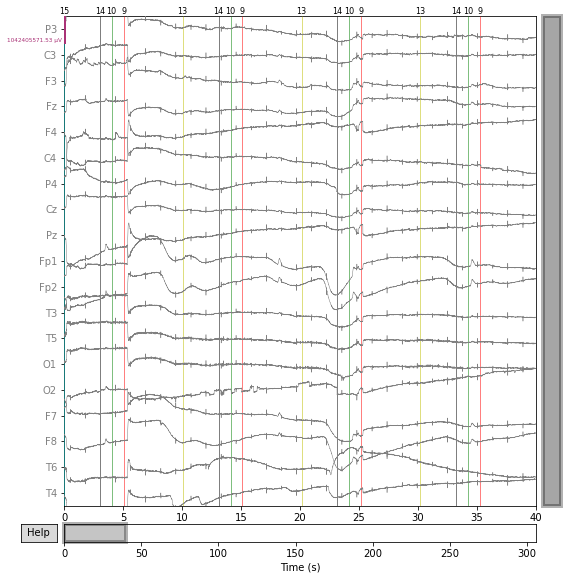

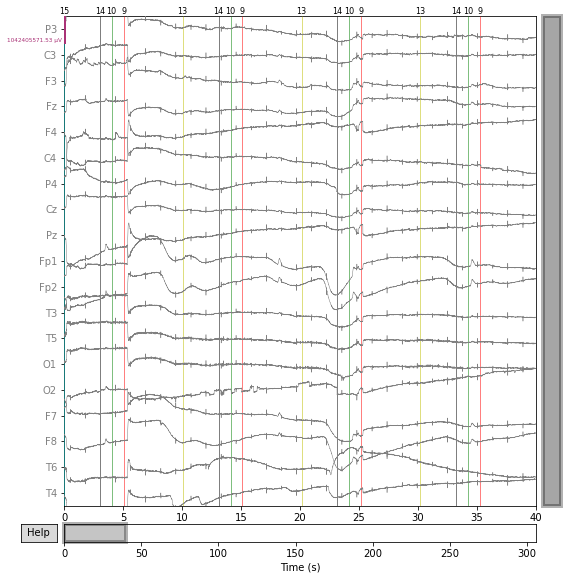

In [15]:
raw.plot(events=np.array(events), start=0, duration=40, color='gray', scalings='auto',
         event_color={9: 'r', 10: 'g', 11: 'b', 12: 'm', 13: 'y', 14: 'k', 15:'c'}, show=False)

#### Using the trigger channel

Using matplotlib as 2D backend.


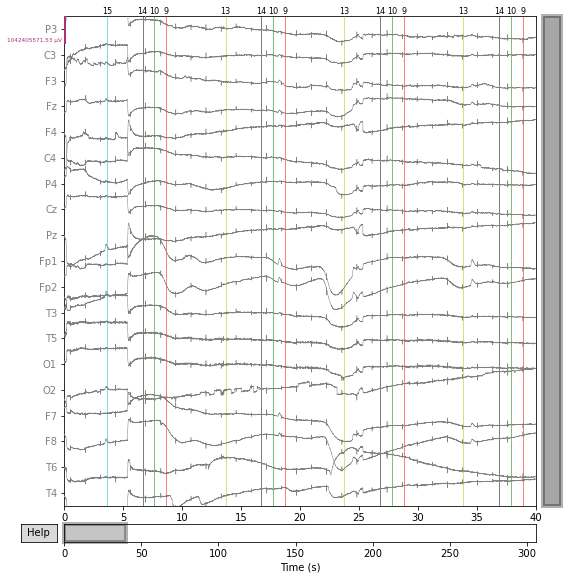

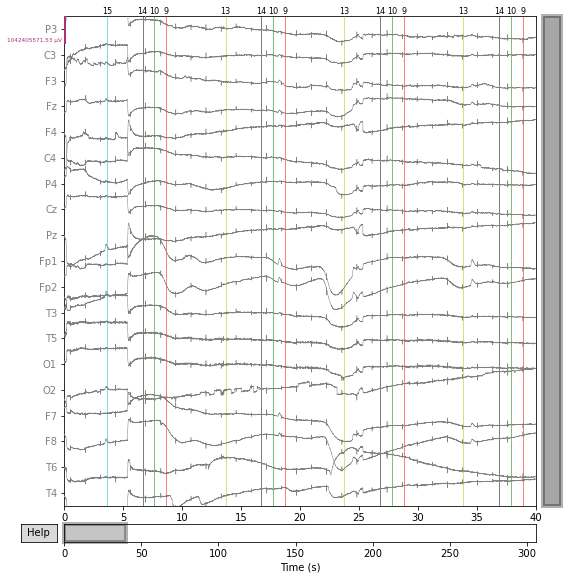

In [8]:
raw.plot(events=trigger_events, start=0, duration=40, color='gray', scalings='auto',
         event_color={9: 'r', 10: 'g', 11: 'b', 12: 'm', 13: 'y', 14: 'k', 15:'c'}, show=False)

In [20]:
events.shape

(121, 3)

## Splitting into epochs
We'll split the signals into epochs corresponding the experiment trials. Each epoch starts at event 14 and ends at event 13.

### Splitting the channels data

In [12]:
# Retrieves the timesteps at which a 14 event happens
epoch_starts = events[np.where(events[:, 2] == 14), 0][0]
# Same for event 13
epoch_ends = events[np.where(events[:, 2] == 13), 0][0]
print(f'Starts: {epoch_starts}\nEnds: {epoch_ends}')

Starts: [  910  3932  6951  9978 13000 16022 19046 22071 25090 28111 31132 34152
 37171 40197 43222 46243 49253 52275 55296 58319 61338 64362 67376 70387
 73405 76418 79438 82461 85480 88502]
Ends: [ 3019  6043  9068 12092 15111 18137 21162 24182 27203 30223 33243 36261
 39290 42313 45336 48344 51368 54385 57411 60430 63451 66467 69479 72494
 75509 78530 81550 84569 87591 90616]


We might want to check that we have as many '13' events as '14':

In [13]:
print(f'Starts: {epoch_starts.shape}, Ends: {epoch_ends.shape}')

Starts: (30,), Ends: (30,)


We can thus proceed to extracting the epochs:

In [14]:
# Extracts each epoch and puts them into a list using the previous arrays
epochs = [raw.get_data()[:, st:end + 1] for st, end in zip(epoch_starts, epoch_ends)]

However all of the epochs don't have *exactly* the same length:

In [15]:
epochs_lengths = [ep.shape[1] for ep in epochs]
print(f'Min epochs length: {min(epochs_lengths)}, Max: {max(epochs_lengths)}')

Min epochs length: 2102, Max: 2120


Since the length aren't so different, we might as well cut all of the epochs to the  
minimal length without losing too much information:

In [16]:
# Cuts each epoch at the minimum length among all epochs
epochs = [ep[:, :min(epochs_lengths)] for ep in epochs]

Now that all epochs have exactly the same amount of timesteps, we can assemble them into a numpy array or a DataFrame:

In [17]:
# Assembles the epochs into an array of shape
# (n_epochs, n_channels, n_timesteps)
epochs = np.stack(epochs)
epochs.shape

(30, 19, 2102)

### Retrieving the groundtruth labels

Now, we also need to retrieve the groundtruth labels of each epoch. Those are indicated with events: 10 & 9 or 12 & 11. Only one of those pairs of events occurs during each epoch.  
Therefore all we need is to check for either event 10 or 12.

In [18]:
# Returns all events 12 or 10 that happened, in chronoligical order
label_events = events[np.where(np.isin(events[:, 2], [12, 10])), 2][0]
label_events

array([10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 10, 12, 10, 10, 10, 10,
       12, 10, 12, 12, 10, 10, 10, 12, 12, 10, 12, 12, 12])

We can check that get as many label as epochs:

In [19]:
label_events.shape

(30,)

Now, we'll convert those labels to 0 and 1 values, more appropriated to an ML task. 1 represents the syllable 'ghi' while 0 represents 'fo'.

In [20]:
epochs_true_labels = (label_events == 12).astype(int)
epochs_true_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1])

### Vizualising the epochs
Let's vizualise the first EEG channel. We'll use a different color for each class (pink for fo, blue for ghi).

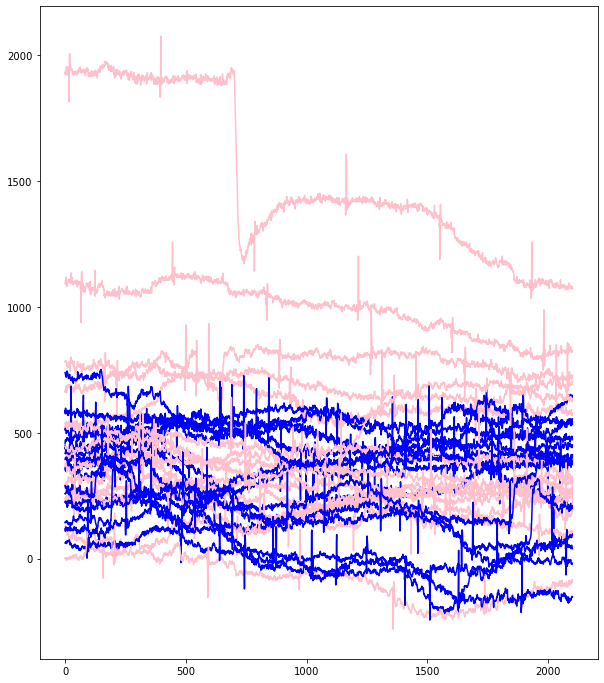

In [27]:
plt.figure(figsize=(10, 12))
X = np.arange(epochs.shape[2])
for epoch, label in zip(epochs, epochs_true_labels):
    if label == 1:
        plt.plot(X, epoch[0], color='blue')
    else:
        plt.plot(X, epoch[0], color='pink')
plt.show()

In [24]:
epochs[0, 0].shape

(2102,)